# Prototyping notebook for future version

In [6]:
import tkinter
import tkinter.filedialog
import cv2 as cv
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.misc
import ipywidgets as widgets
import os

data_dir  = tkinter.filedialog.askdirectory()
files = os.listdir(data_dir)

@widgets.interact(i = (0, len(files)-1, 1))
def choose_file(i):
    path = os.path.join(data_dir, files[i])
    hdul = fits.open(path)
    angle = hdul[0].header['Sample Theta']
    data = hdul[2].data
    hdul.close()
    image = cv.normalize(data, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    plt.imshow(image, cmap='gray')
    plt.title('Angle: {}'.format(angle))
    return files[i], image

interactive(children=(IntSlider(value=84, description='i', max=169), Output()), _dom_classes=('widget-interact…

In [7]:
path = os.path.join(data_dir, files[85])
hdul = fits.open(path)
image = hdul[2].data

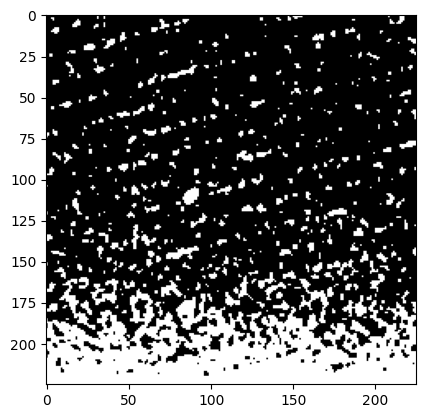

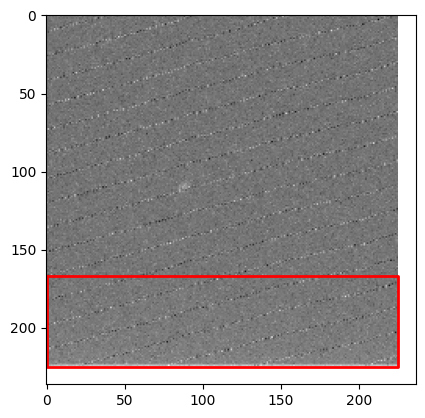

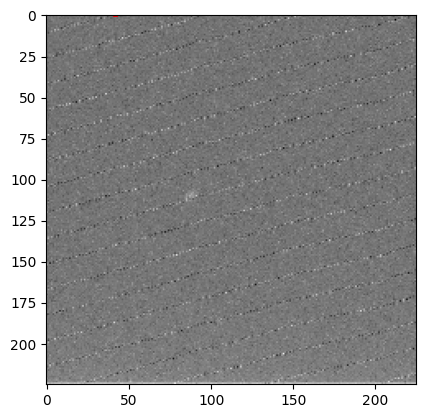

In [10]:
processed = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX).astype(
    np.uint8
)

# Apply a Gaussian blur to reduce noise
blurred_image = cv.GaussianBlur(processed, (2, 2), 0)
# Threshold the image to create a binary image
_, threshold_image = cv.threshold(
    blurred_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)#

plt.imshow(threshold_image, cmap='gray')
plt.show()

# find the contours from the threshold image
contours, _ = cv.findContours(
    threshold_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
)

largest_contour = None
largest_contour_area = 0
for contour in contours:
    contour_area = cv.contourArea(contour)
    if contour_area > largest_contour_area:
        largest_contour = contour
        largest_contour_area = contour_area

# Determine the bounding rectangle for the largest contour
x, y, w, h = cv.boundingRect(largest_contour)

# Display the image with the bounding rectangle
plt.imshow(image, cmap="gray")
plt.plot(
    [x, x + w, x + w, x, x], [y, y, y + h, y + h, y], "r", linewidth=2
)
plt.show()

# Display the raw contours
plt.imshow(image, cmap="gray")
plt.plot(contour[:, :, 0], contour[:, :, 1], 'r', linewidth=2)
plt.show()

In [10]:
moments = cv.moments(largest_contour)
centroid_x = int(moments["m10"] / moments["m00"])
centroid_y = int(moments["m01"] / moments["m00"])
direct_beam = (centroid_x, centroid_y)
direct_beam

(81, 109)

In [11]:
mask = np.zeros_like(image)
cv.drawContours(mask, [largest_contour], 0, 255, -1)
masked_image = cv.bitwise_and(image, mask)

cv.imshow("Image", image)
cv.imshow("Processed", processed)
cv.imshow("Blurred Image", blurred_image)
cv.imshow("Threshold Image", threshold_image)
cv.imshow("Masked Image", masked_image)
cv.waitKey(0)

-1

# Rust

In [36]:
:dep astrors
:dep polars
:dep numpy
:dep plotters
:dep glob
:dep regex
:dep ndarray

In [48]:
use std::path::Path;
use std::fs::File;
use glob::glob;
use polars::prelude::*;
use regex::Regex;
use astrors::io;
use ndarray::Array2;

// Formats for Data that could be found in the experiment data directory
#[derive(Debug)]
enum DataFormat {
    Fits(Fits),
    Csv(Csv),
    Temp(Temp),
}

// Polarization of the data
#[derive(Debug)]
enum Pol {
    S,
    P,
    N,
}

// Structures to hold the data
#[derive(Debug)]
struct DataFile {
    id: SampleID,
    data: Option<DataFormat>,
}

#[derive(Debug)]
struct SampleID {
    name: String,
    scan_id: u32,
    file_id: u32,
}

#[derive(Debug)]
struct Fits {
    pol: Pol,
    energy: f64,
    current: f64,
    hos: f64,
    hes: f64,
    exposure: f64,
    theta: f64,
    image: io::hdus::image::image::ImageData,
}

#[derive(Debug)]
struct Csv {}

#[derive(Debug)]
struct Temp {}

// Implementations for these data structures
impl DataFile {
    fn new(id: SampleID, data: Option<DataFormat>) -> Self {
        DataFile { id, data }
    }

    fn read_file(file: &str) -> Self {
        let file_name = Path::new(file).file_name().unwrap().to_str().unwrap();
        let (id, kind) = SampleID::parse_file_name(file_name);
        let data = match kind {
            "fits" => Some(DataFormat::Fits(Fits::from_file(file))),
            "csv" => Some(DataFormat::Csv(Csv::from_file(file))),
            "temp" => Some(DataFormat::Temp(Temp::from_file(file))),
            _ => None,
        };
        DataFile::new(id, data)
    }
}

impl SampleID {
    fn new(name: String, scan_id: u32, file_id: u32) -> Self {
        SampleID { name, scan_id, file_id }
    }

    fn parse_file_name(file_name: &str) -> (Self, &str) {
        if file_name.contains("Captured Image") {
            let parts: Vec<&str> = file_name.split("Captured Image ").collect();
            return (
                Self {
                    name: String::from("Capture"),
                    scan_id: parts[1].split(" ").collect::<Vec<&str>>()[1].parse::<u32>().unwrap(),
                    file_id: 0,
                },
                "temp",
            );
        } else {
            let re = Regex::new(r"([0-9]{5})-(\d+)\.fits$").unwrap();
            if let Some(caps) = re.captures(file_name) {
                let scan_id = caps.get(1).unwrap().as_str().to_string();
                let file_id = caps.get(2).unwrap().as_str().to_string();
                let sample_name = file_name.split(scan_id.as_str()).collect::<Vec<&str>>()[0]
                    .trim_end_matches('-')
                    .to_string();
                return (
                    Self {
                        name: sample_name,
                        scan_id: scan_id.parse().unwrap(),
                        file_id: file_id.parse().unwrap(),
                    },
                    "fits",
                );
            } else {
                panic!("Invalid file: {}", file_name);
            }
        }
    }
}

impl Fits {
    fn new(pol: Pol, energy: f64, current: f64, hos: f64, hes: f64, exposure: f64, theta: f64, image: io::hdus::image::image::ImageData) -> Self {
        Fits { pol, energy, current, hos, hes, exposure, theta , image }
    }

    fn from_file(file: &str) -> Self {
        let mut fits_file = File::open(file).unwrap();
        let mut header = io::Header::new();
        header.read_from_file(&mut fits_file)?;

        let image_hdu = io::hdus::image::image::ImageParser::read_from_buffer(&mut fits_file, &mut header)?;

        let pol_card = match header.get_card("EPU Polarization") {
            Some(card) => card.value.to_string(),
            None => String::from("N/A"),
        };
        let pol_state = match pol_card.as_str() {
            "100" => Pol::S,
            "190" => Pol::P,
            _ => Pol::N,
        };
        let energy = header.get_card("Beamline Energy").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let theta = header.get_card("Sample Theta").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let current = header.get_card("Beam Current").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let exposure = header.get_card("EXPOSURE").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let hos = header.get_card("Higher Order Suppressor").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));
        let hes = header.get_card("Horizontal Exit Slit Size").map_or(0.0, |card| card.value.as_float().unwrap_or(0.0));

        let image = image_hdu.data;

        Fits::new(pol_state, energy, current, hos, hes, exposure, theta, image)
    }
}

impl Csv {
    fn new() -> Self {
        Csv {}
    }

    fn from_file(_file: &str) -> Self {
        Csv::new()
    }
}

impl Temp {
    fn new() -> Self {
        Temp {}
    }

    fn from_file(_file: &str) -> Self {
        Temp::new()
    }
}


Error: the `?` operator can only be used in a method that returns `Result` or `Option` (or another type that implements `FromResidual`)

Error: the `?` operator can only be used in a method that returns `Result` or `Option` (or another type that implements `FromResidual`)

Error: no field `data` on type `ImageData`

In [42]:
let file = r"C:\Users\hduva\pyref\src\refl\ZnPc82862-00001.fits";
let out = DataFile::read_file(file);

In [43]:
println!("{:#?}", out);

DataFile {
    id: SampleID {
        name: "ZnPc",
        scan_id: 82862,
        file_id: 1,
    },
    data: Some(
        Fits(
            Fits {
                pol: S,
                energy: 283.702099502383,
                current: 499.725799560547,
                hos: 8.79951333595377,
                hes: 3000.0,
                exposure: 0.00100000004749745,
                theta: 0.0,
                image: FitsData::U8([[190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190],
                 [11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82, 190, 11, 242, 82,